## Iris Dataset classification prediction using PyTorch


From Wikipedia:

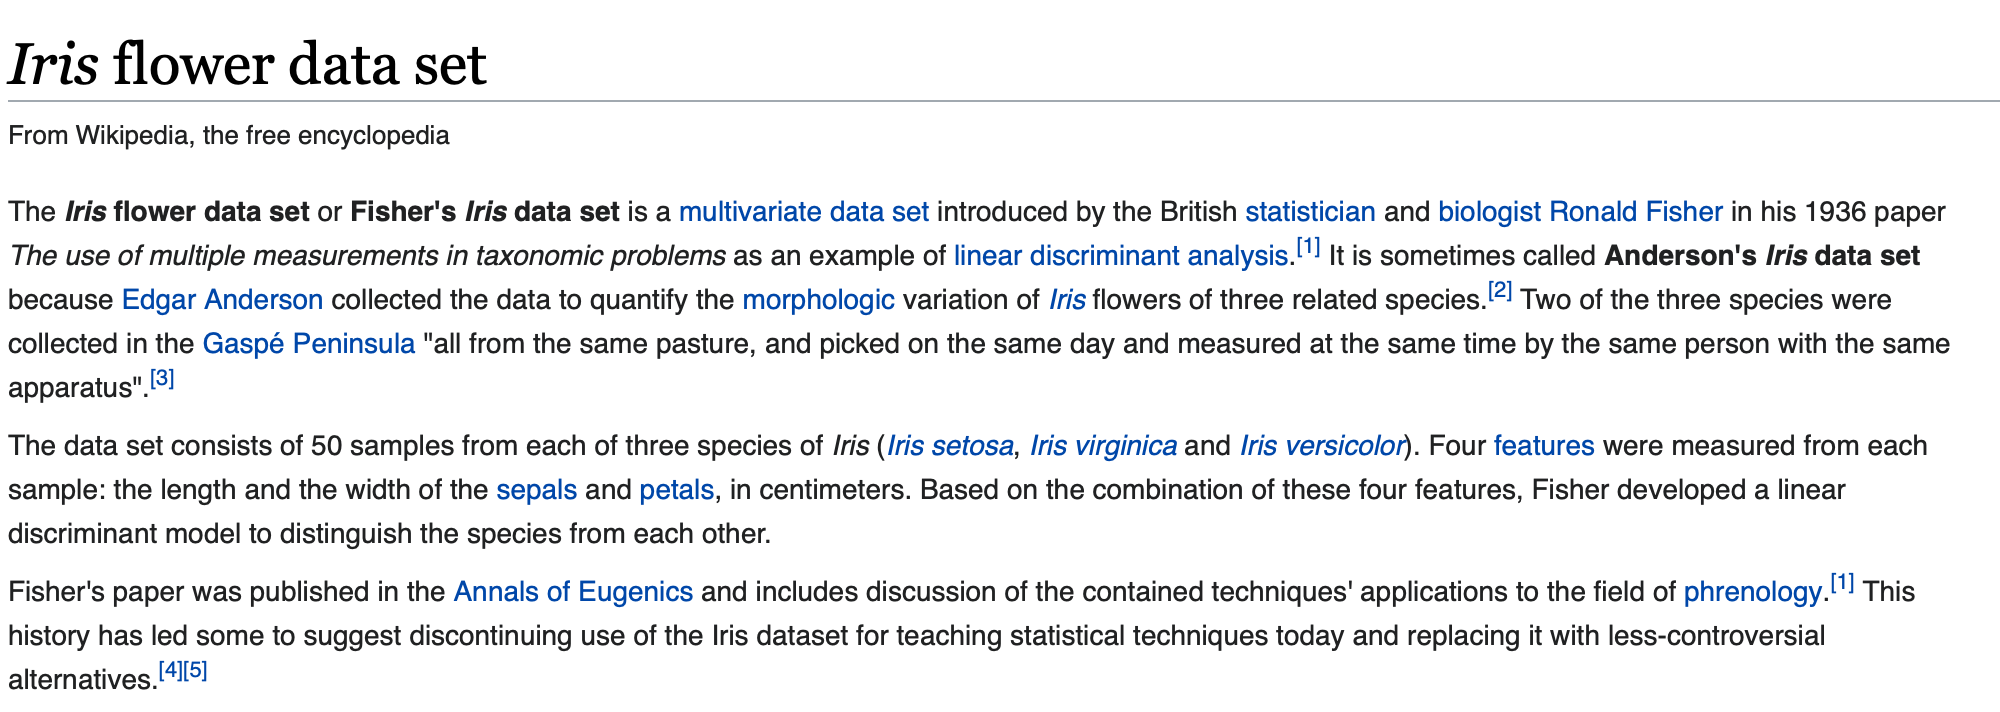

## Reference:
Thanks for excellent tutorial for Pytorch!
https://www.youtube.com/watch?v=lfQs6JEkhTU

### This example will use petal and sepal width and length to predict the flower. This is a simple use PyTorch classification.

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns


In [2]:
from sklearn import datasets

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
SEED = 1239
torch.manual_seed(SEED)


In [4]:
if torch.backends.mps.is_available():
    torch.cuda.manual_seed(SEED)  #will it work?

    
np.random.seed(SEED)

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ['sepal_l','sepal_w','petal_l','petal_w'] + ['target'])

In [6]:
df = df.astype(np.float32)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   sepal_l  150 non-null    float32
 1   sepal_w  150 non-null    float32
 2   petal_l  150 non-null    float32
 3   petal_w  150 non-null    float32
 4   target   150 non-null    float32
dtypes: float32(5)
memory usage: 3.1 KB


In [35]:
df.describe()

,sepal_l,sepal_w,petal_l,petal_w,target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


## EDA

data contains three types of flowers, and the sample contains 50 of each, total 150.

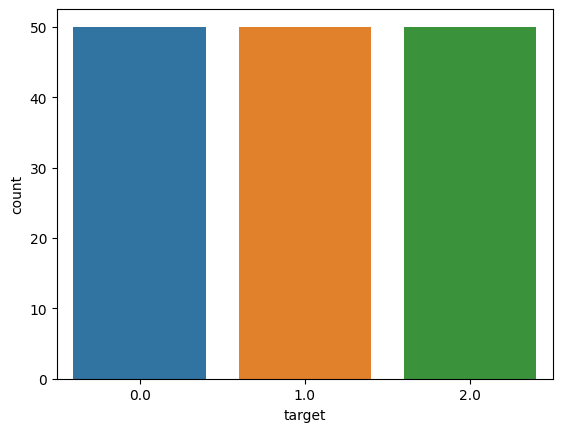

In [9]:
ax = sns.countplot(x="target", data=df)

##### Check for null values

In [10]:
df.isnull().values.any()


False

There are no null values in our dataset

##### How the values are distributed for each columns

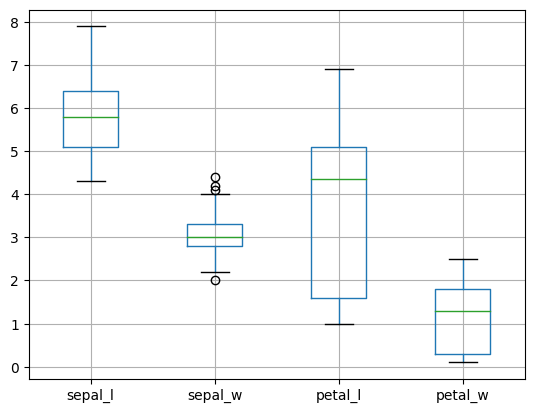

In [11]:
boxplot = df.boxplot(column=['sepal_l','sepal_w','petal_l','petal_w'])  

There seems to be no outliers.

<AxesSubplot: xlabel='sepal_l', ylabel='sepal_w'>

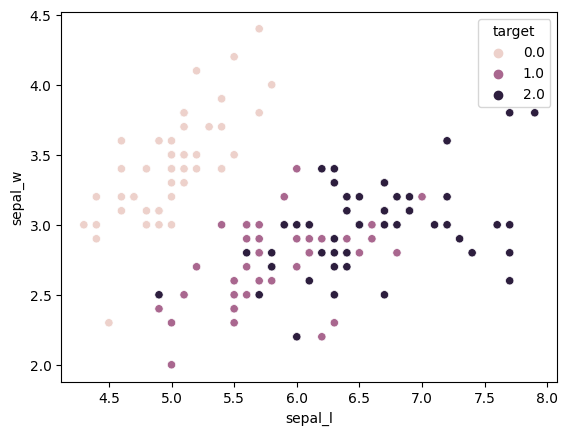

In [12]:
sns.scatterplot(x="sepal_l", y="sepal_w", hue='target', data=df)

<AxesSubplot: xlabel='petal_l', ylabel='petal_w'>

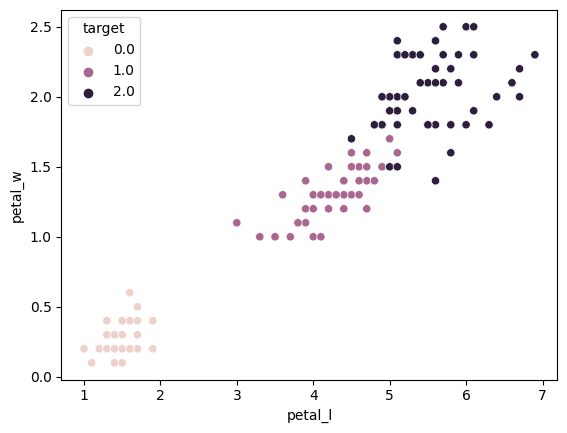

In [13]:
sns.scatterplot(x="petal_l", y="petal_w", hue='target', data=df)

<AxesSubplot: xlabel='petal_l', ylabel='sepal_l'>

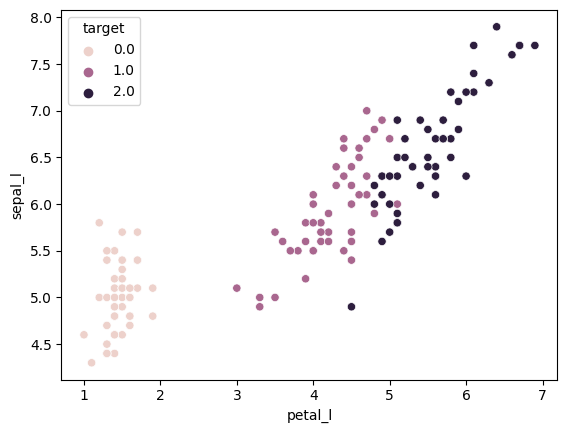

In [14]:
sns.scatterplot(x="petal_l", y="sepal_l", hue='target', data=df)

<AxesSubplot: xlabel='petal_w', ylabel='sepal_w'>

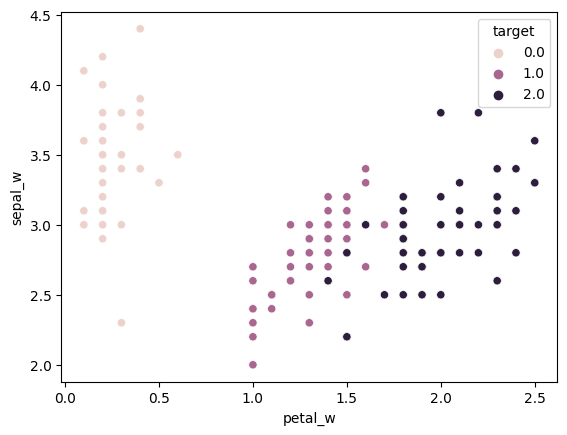

In [15]:
sns.scatterplot(x="petal_w", y="sepal_w", hue='target', data=df)

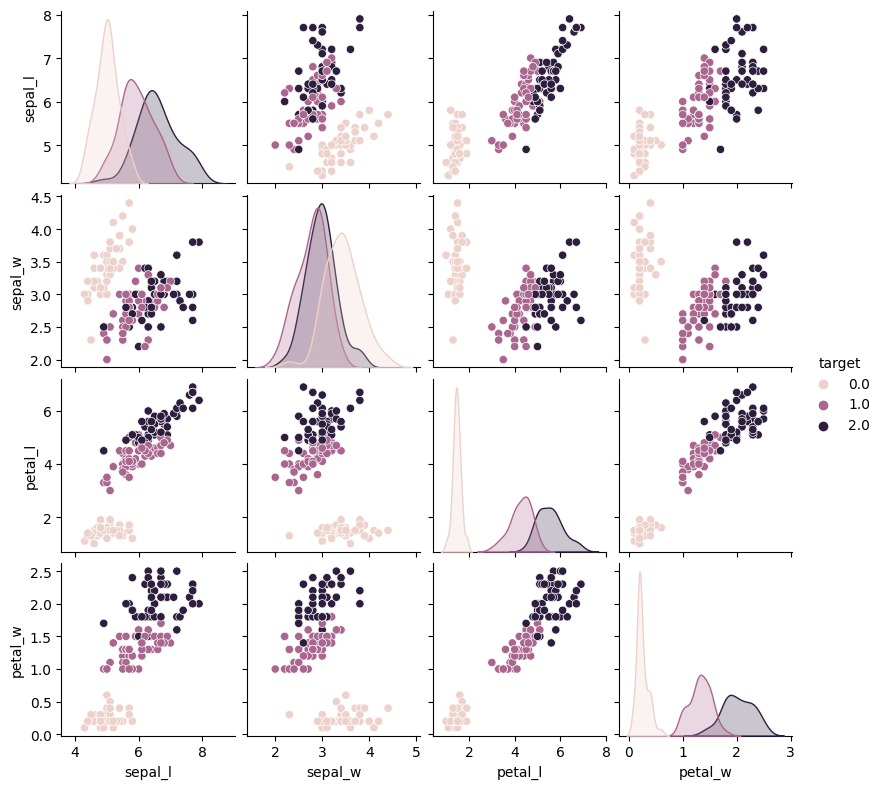

In [37]:

sns.pairplot(df,hue='target', height=2)


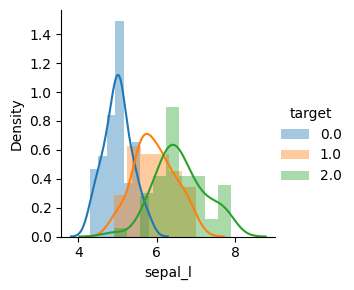

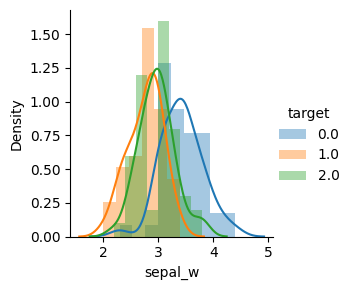

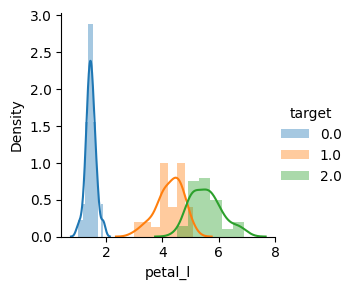

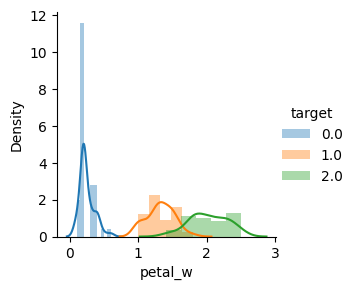

In [41]:
plot = sns.FacetGrid(df, hue="target")
plot.map(sns.distplot, "sepal_l").add_legend()

plot = sns.FacetGrid(df, hue="target")
plot.map(sns.distplot, "sepal_w").add_legend()

plot = sns.FacetGrid(df, hue="target")
plot.map(sns.distplot, "petal_l").add_legend()

plot = sns.FacetGrid(df, hue="target")
plot.map(sns.distplot, "petal_w").add_legend()

plt.show()


There are some correlation between petal and sepal length and width of various types of flowers. 

In [16]:
n = len(df.index)
new_indices = np.random.permutation(n)
df = df.iloc[new_indices]

In [17]:
y = df ['target']
X = df.drop('target', axis=1)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X,y)


In [19]:
X_scaled[:10]

array([[ 1.1591729e+00, -1.3197948e-01,  9.9010795e-01,  1.1855671e+00],
       [ 1.6438439e+00,  3.2841417e-01,  1.2742952e+00,  7.9067063e-01],
       [-1.7367418e-01, -1.2829634e+00,  7.0592082e-01,  1.0539351e+00],
       [-4.1600969e-01, -1.0527668e+00,  3.6489633e-01,  8.7762193e-04],
       [-1.1430168e+00,  1.2492008e+00, -1.3402265e+00, -1.4470764e+00],
       [-1.1430168e+00,  9.8217063e-02, -1.2833891e+00, -1.3154444e+00],
       [-2.9484195e-01, -3.6217603e-01, -8.9803182e-02,  1.3250968e-01],
       [ 3.1099743e-01, -5.9237313e-01,  5.3540844e-01,  8.7762193e-04],
       [ 2.4920194e+00,  1.7095945e+00,  1.5016450e+00,  1.0539351e+00],
       [ 6.8661921e-02,  3.2841417e-01,  5.9224612e-01,  7.9067063e-01]],
      dtype=float32)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(),
                                                    stratify=y, 
                                                    test_size=.4)

In [21]:
X_train.shape, y_train.shape
x_shape = X_train.shape
y_shape = y_train.shape



In [22]:
input_size = x_shape[1]
output_size = len(np.unique(y_train))

In [23]:
print(input_size,output_size)

4 3


## Dataset Class

The dataset class defines a class where data exists. It has two types, test dataset and train dataset. Each type will hold the corresponding data.

In [24]:
class IrisDataset(Dataset):
    def __init__(self, data,label):
        assert len(data) == len(label)
        
        self.data = torch.from_numpy(data)
        self.label =torch.from_numpy(label)
        
    def __getitem__ (self,index):
        return self.data[index], self.label[index]
    
    def __len__(self):
        return len(self.label)
    



#### Load data to dataloader dataset

In [25]:
train_data = IrisDataset(X_train,y_train)
test_data = IrisDataset(X_test,y_test)


train_dataloader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = False
)

test_dataloader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = False
)

### Create neural network

#### Attach to MPS (Metal), else CPU

In [26]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [27]:
device

device(type='mps')

In [28]:
class IrisNeuralNetwork(nn.Module):
    def __init__(self):
        super(IrisNeuralNetwork, self).__init__()
        
        self.fn1 = nn.Linear(input_size,6)
        self.fn2 = nn.Linear(6,output_size)
        
    def forward(self,x):
        x = F.relu(self.fn1(x))
        x = self.fn2(x)
        return x
        

In [29]:
model = IrisNeuralNetwork()
model.to(device)

IrisNeuralNetwork(
  (fn1): Linear(in_features=4, out_features=6, bias=True)
  (fn2): Linear(in_features=6, out_features=3, bias=True)
)

In [30]:
x,y = next(iter(train_dataloader))
x = x[:5].to(device)
score = model(x)
print(score)

tensor([[ 1.9031,  0.1955,  1.9378],
        [ 1.7876,  0.2963,  1.9375],
        [ 1.1618,  0.2885,  2.1160],
        [ 1.6410,  0.2266,  1.9201],
        [ 1.6470, -0.0170,  1.9157]], device='mps:0',
       grad_fn=<LinearBackward0>)


/Users/ravis/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torch/_tensor_str.py:114: UserWarning: The operator 'aten::masked_select' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1663398524453/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


## Loss Function and Optimizer

Cross Entropy Loss and Adam Optimizer


In [31]:

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.01)


In [32]:
def train():
    model.train()
    
    i_count = 1
    for x,y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        n = x.size(0)
        
        optimizer.zero_grad()
        score = model(x)
        y = y.type(torch.LongTensor)
        y = y.to(device)
        loss = loss_function(score,y)

        
        loss.backward()
        optimizer.step()
        
        predictions = score.max(1, keepdim=True)[1]
        num_correct = predictions.eq(y.view_as(predictions)).sum().item()
        i_count=i_count+1
        
    accuracy = num_correct /n
    return loss, accuracy
        

In [33]:
def evaluate():
    model.eval()
    
    with torch.no_grad():
        for x,y in test_dataloader:
            x = x.to(device)
            
            n = x.size(0)

            score = model(x)
            y = y.type(torch.LongTensor)
            y = y.to(device)
            loss = loss_function(score,y)

            predictions = score.max(1, keepdim=True)[1]
            num_correct = predictions.eq(y.view_as(predictions)).sum().item()
        
    accuracy = num_correct /n 
    return loss, accuracy

In [34]:
max_epochs = 80
for epoch in range(max_epochs):
    tr_loss, tr_acc = train()
    eva_loss, eva_acc = evaluate()
    
        
    print('[{}/{}] Train loss:{:.4f} acc:{:.2f}% -- Test Loss:{:.4f} acc:{:.2f}%'.format(
        epoch, max_epochs, tr_loss,tr_acc*100, eva_loss, eva_acc*100
    ))
    
    if eva_acc >= 1:
        break

[0/80] Train loss:1.3220 acc:3.85% -- Test Loss:1.2136 acc:26.92%
[1/80] Train loss:1.1661 acc:46.15% -- Test Loss:1.1273 acc:38.46%
[2/80] Train loss:1.1361 acc:15.38% -- Test Loss:1.1329 acc:26.92%
[3/80] Train loss:1.1405 acc:26.92% -- Test Loss:1.1172 acc:26.92%
[4/80] Train loss:1.0984 acc:23.08% -- Test Loss:1.0635 acc:15.38%
[5/80] Train loss:1.0407 acc:26.92% -- Test Loss:1.0143 acc:57.69%
[6/80] Train loss:1.0012 acc:57.69% -- Test Loss:0.9879 acc:57.69%
[7/80] Train loss:0.9836 acc:57.69% -- Test Loss:0.9775 acc:57.69%
[8/80] Train loss:0.9766 acc:57.69% -- Test Loss:0.9722 acc:57.69%
[9/80] Train loss:0.9720 acc:57.69% -- Test Loss:0.9675 acc:57.69%
[10/80] Train loss:0.9681 acc:57.69% -- Test Loss:0.9639 acc:57.69%
[11/80] Train loss:0.9659 acc:57.69% -- Test Loss:0.9616 acc:57.69%
[12/80] Train loss:0.9637 acc:57.69% -- Test Loss:0.9573 acc:53.85%
[13/80] Train loss:0.9566 acc:42.31% -- Test Loss:0.9458 acc:50.00%
[14/80] Train loss:0.9405 acc:42.31% -- Test Loss:0.9252 ac